In [1]:
import proposal as pp
import numpy as np
import matplotlib.pyplot as plt

N_SAMPLES = 100

# Interaction Object

In [2]:
args = {
    "particle_def": pp.particle.MuMinusDef(),
    "target": pp.medium.Ice(),
    "interpolate": True,
    "cuts": pp.EnergyCutSettings(500, 1, False)
}
pp.InterpolationDef.path_to_tables = "/home/msackel/.local/share/PROPOSAL/"
pp.InterpolationDef.order_of_interpolation = 5

cross = pp.crosssection.make_std_crosssection(**args)
inter = pp.make_interaction(cross, False)

## Sampling Energie where next stochastic interaction take place

Text(0, 0.5, 'energy / MeV')

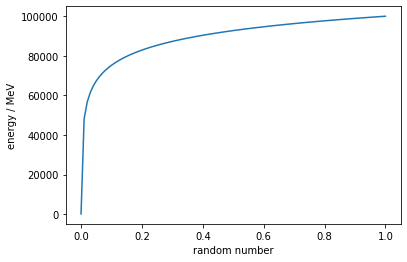

In [3]:
energie = 1e5
rnd = np.linspace(1e-5,1,100)
plt.plot(rnd, inter.energy_interaction(energie, rnd))
plt.xlabel("random number")
plt.ylabel("energy / MeV")

## Mean free path length

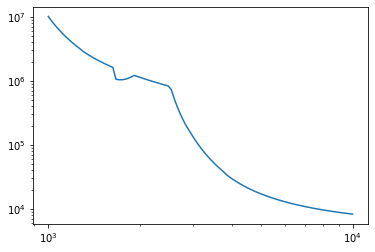

In [12]:
energies = np.geomspace(1e3, 1e4, 100)
plt.plot(energies, inter.mean_free_path(energies))
plt.xscale("log")
plt.yscale("log")

## Compined Rates

In [13]:
rates_comp_inter = {}
for e in energies:
    for cross, comp, r in inter.rates(e):
        if (cross.type, comp) in rates_comp_inter:
            rates_comp_inter[(cross.type, comp)].append(r)
        else:
            rates_comp_inter[(cross.type, comp)] = [r]            

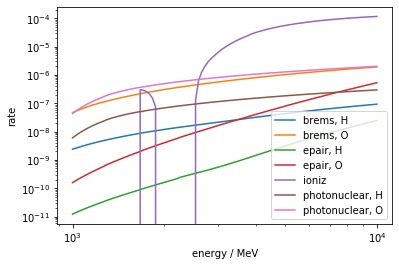

In [14]:

for (cross_type, comp), values in rates_comp_inter.items():
    if comp:
        label = f"{cross_type.name}, {comp.name}"
    else:
        label = f"{cross_type.name}"
    plt.plot(energies, values, label=label)
plt.xlabel("energy / MeV")
plt.ylabel("rate")
plt.xscale("log")
plt.yscale("log")
plt.legend()

## Sample Loss

In [7]:
import random
energy = 1e5
rates = inter.rates(energy)

rates_dict = {}
for cross, comp, _ in rates:
    rates_dict[(cross.type.name, comp)] = []

N_RND = int(1e5)
rnds = np.linspace(0, 1, N_RND)
for rnd in rnds:
    loss_type, comp, v = inter.sample_loss(energy, rates, rnd)
    rates_dict[(loss_type.name, comp)].append(v)

order = np.argsort([len(x) for x in rates_dict.values()])
reordered_keys = [list(rates_dict.keys())[i] for i in order]
reordered_dict = {k: rates_dict[k] for k in reordered_keys}

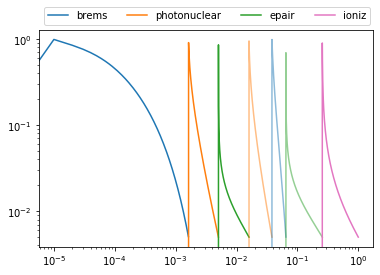

In [8]:
colors = {}
alphas = {}
pos = 0
for i, ((cross, comp), values) in enumerate(reordered_dict.items()):
    label = None
    if cross not in colors:
        colors[f"{cross}"] = f"C{i}"
        label = f"{cross}"
    color = colors[f"{cross}"]
    if comp:
        if f"{comp.name}" not in alphas:
            alphas[f"{comp.name}"] = 1 / (len(alphas)+1)
        alpha = alphas[f"{comp.name}"]
    else:
        alpha = 1
    rnd = np.linspace(pos, pos+len(values), len(values)+1) /N_RND
    plt.plot(
        rnd, 
        np.append(0,values), 
        label=label, 
        color=color, 
        alpha=alpha
    )
    pos += len(values)
plt.xscale("log")
plt.yscale("log")
plt.legend(loc='lower left', bbox_to_anchor=(0, 1.), ncol=4)